In [3]:
# Enable auto-reloading so edits in utils.py update immediately
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import warnings

from utils import CausalNavigator, load_cdc_data, preprocess_for_causal

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv
filename = 'diabetes_binary_health_indicators_BRFSS2015.csv'
DATA_PATH = os.path.join('data', 'unprocessed', filename)
try:
    df_raw = load_cdc_data(DATA_PATH)
    # We use a subset of columns for the API demo
    df_clean, X, T, Y = preprocess_for_causal(
        df_raw, 
        treatment_col='PhysActivity', 
        outcome_col='Diabetes_binary', 
        covariate_cols=['HighBP', 'HighChol', 'Age', 'Income', 'Sex', 'GenHlth', 'BMI']
    )
    # Subsample 10k rows for speed
    sample_indices = np.random.choice(X.index, size=10000, replace=False)
    X_demo, T_demo, Y_demo = X.loc[sample_indices], T.loc[sample_indices], Y.loc[sample_indices]
    print(f"API Demo Data Loaded. Shape: {X_demo.shape}")
    display(X_demo.head())

except Exception as e:
    print(f"Error: {e}")

Loading data from: data/unprocessed/diabetes_binary_health_indicators_BRFSS2015.csv
Dropped 24206 duplicate rows.
API Demo Data Loaded. Shape: (10000, 7)


,HighBP,HighChol,Age,Income,Sex,GenHlth,BMI
229618,0.0,0.0,4.0,7.0,1.0,3.0,25.0
39034,0.0,1.0,10.0,8.0,1.0,2.0,27.0
179047,0.0,0.0,8.0,1.0,0.0,5.0,39.0
235692,0.0,1.0,11.0,7.0,0.0,3.0,32.0
218949,0.0,0.0,3.0,7.0,0.0,3.0,23.0


In [15]:
# Initialize the CausalNavigator
navigator = CausalNavigator(
    learner_type='X', 
    control_name='Sedentary', 
    treatment_name='Active'
)

Calculating Propensity Scores for Overlap Check...


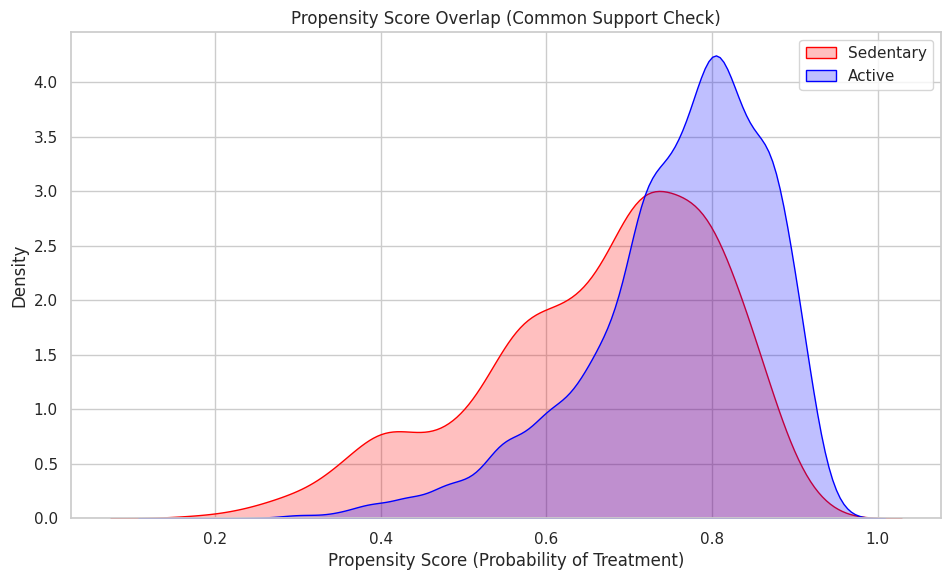


--- Diagnostic Interpretation ---
Good Overlap: The red and blue distributions share the same x-axis range.
Bad Overlap: One group is clustered at 0 and the other at 1 (Positivity Violation).



In [16]:
# Check if there is "Common Support" between the treated and control groups.
navigator.check_overlap(X_demo, T_demo)

In [17]:
# Estimate Effects
cate_estimates = navigator.fit_estimate(X_demo, T_demo, Y_demo)
print(f"\nAverage Treatment Effect (ATE): {cate_estimates.mean():.4f}")

Mapping labels: 0.0 -> Sedentary, 1.0 -> Active
Training X-Learner with XGBoost base models...
Done. Estimated Average Treatment Effect (ATE): -0.0024

Average Treatment Effect (ATE): -0.0024


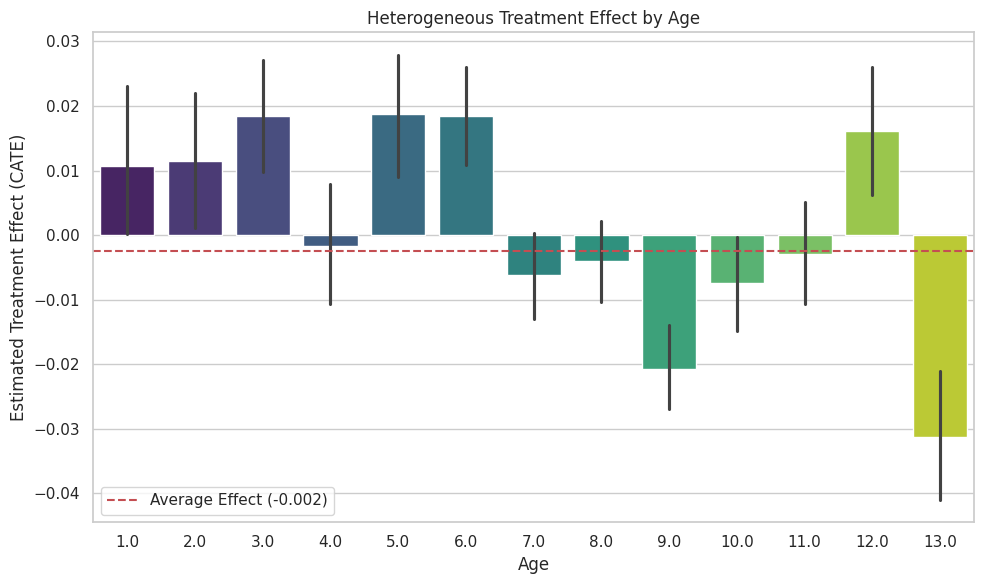

In [18]:
# Visualize Results
df_results = navigator.get_cate_df(X_demo)
navigator.plot_heterogeneity(df_results, col='Age')

In [ ]:
# Robustness Check: Placebo Test
# We shuffle T to see if the model finds an effect where none exists.
navigator.run_placebo_test(X_demo, T_demo, Y_demo, n_simulations=3)

In [ ]:
# Sensitivity Analysis
# Check how stable the result is when removing one covariate at a time.
navigator.run_sensitivity_analysis(X_demo, T_demo, Y_demo)

In [ ]:
# Estimator Comparison ("Horse Race")
# Compare X-Learner against S, T, R, and DR Learners using Uplift Curves.
navigator.compare_estimators(X_demo, T_demo, Y_demo)